In [0]:
from google.colab import drive 
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

import datetime
import io

#to visualize data
import seaborn as sns
import plotly.express as px

from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm

In [0]:
# load dataset
dropped_comumns = ['Unnamed: 0','No plan','No disposition','Code type local','Code voie','Mois mutation','Jour mutation','Nombre de lots']
df0 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DVF/data/data.csv')
df0=df0.drop(dropped_comumns,axis=1)

In [0]:
df0=df0.dropna(subset = ['Valeur fonciere'])

In [0]:
df0['Code postal'] = df0['Code postal'].astype(str)
df0['Code departement'] = df0['Code departement'].astype(str)
df0['Code commune'] = df0['Code commune'].astype(str)

In [0]:
df0['Date mutation']=pd.to_datetime(df0['Date mutation']).dt.date

In [0]:
#make a copy of data
data=df0.copy()
#df=df0.copy()

## outliers

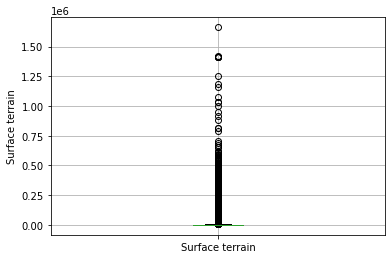

In [0]:
for var in ['Surface terrain']:
    plt.figure(figsize=(6,4))
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    plt.show()

## Separate dataset into train and test



In [0]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['Valeur fonciere'],
                                                    test_size=0.2,
                                                    # we are setting the seed here:
                                                    random_state=0)  

X_train.shape, X_test.shape

((1808616, 16), (452154, 16))

## Missing values


### Categorical variables
For categorical variables, we will replace missing values with the string "missing".

In [0]:
data.columns

Index(['Date mutation', 'Nature mutation', 'Valeur fonciere', 'No voie',
       'Type de voie', 'Voie', 'Code postal', 'Commune', 'Code departement',
       'Code commune', 'Section', 'Type local', 'Surface reelle bati',
       'Nombre pieces principales', 'Nature culture', 'Surface terrain'],
      dtype='object')

In [0]:
categorical=['Nature mutation',
       'Type de voie','Voie', 'Code postal', 'Commune',
       'Code departement', 'Code commune', 'Section',
       'Type local','Nature culture']

In [0]:
# make a list of the categorical variables that contain missing values

vars_with_na = [
    var for var in categorical
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O'
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

Type de voie      0.437116
Voie              0.005693
Section           0.000024
Type local        0.467747
Nature culture    0.280715
dtype: float64

In [0]:
# replace missing values with new label: "Missing"

X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

In [0]:
# check that we have no missing information in the engineered variables
X_train[vars_with_na].isnull().sum()

Type de voie      0
Voie              0
Section           0
Type local        0
Nature culture    0
dtype: int64

In [0]:
# check that test set does not contain null values in the engineered variables
[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

### Numerical variables

To engineer missing values in numerical variables, we will:

- add a binary missing value indicator variable
- and then replace the missing values in the original variable with the mode


In [0]:
numerical=[var for var in data.columns if var not in categorical and var!='Date mutation' ]

In [0]:
numerical

['Valeur fonciere',
 'No voie',
 'Surface reelle bati',
 'Nombre pieces principales',
 'Surface terrain']

In [0]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in numerical
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O'
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

No voie                      0.419232
Surface reelle bati          0.468395
Nombre pieces principales    0.468395
Surface terrain              0.280715
dtype: float64

In [0]:
# replace engineer missing values as we described above

for var in vars_with_na:

    # calculate the mode using the train set
    mean_val = X_train[var].mean()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(mean_val)
    X_test[var] = X_test[var].fillna(mean_val)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

No voie                      0
Surface reelle bati          0
Nombre pieces principales    0
Surface terrain              0
dtype: int64

In [0]:
# check that test set does not contain null values in the engineered variables

[vr for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

## Temporal variables

### Capture elapsed time


In [0]:
def elapsed_days(df):
    # capture the day in the year
    d=datetime.date(2019,1,1)
    df['Date mutation'] = (df['Date mutation'] - d).dt.days
    return df

In [0]:
X_train = elapsed_days(X_train)
X_test = elapsed_days(X_test)

In [0]:
X_train['Date mutation'].head()

1437941    311
273038     209
1975083    183
1783814    156
1663860     57
Name: Date mutation, dtype: int64

## Numerical variable transformation


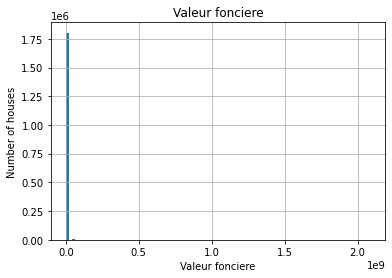

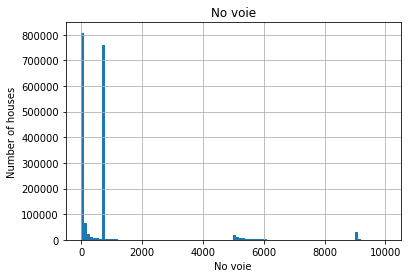

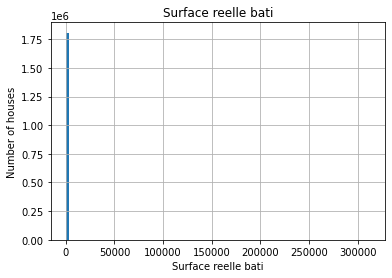

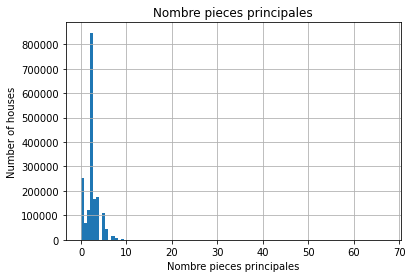

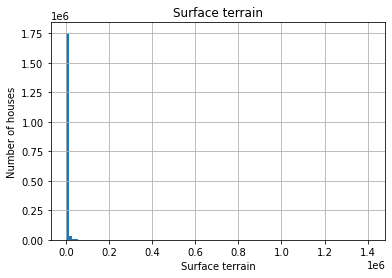

In [0]:
continuous = ['Valeur fonciere', 'Surface reelle bati', 'Surface terrain']
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=100)
    plt.ylabel('Number of houses')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in numerical:
    analyse_continuous(X_train, var)

In [0]:
data.shape

(2260770, 16)

In [0]:
data[data['Valeur fonciere'] <= 0].shape

(0, 16)

In [0]:
data[data['Surface reelle bati'] <= 0].shape

(236544, 16)

In [0]:
data[data['Surface terrain'] <= 0].shape

(50, 16)

In [0]:
# so we can apply the log to our variables we need to make sure there is not <= 0 values 
def delete_zeros(df,var):
    df = df[df[var] > 0]
    return df

for var in numerical:
    data = delete_zeros(data,var)
    X_train = delete_zeros(X_train,var)
    X_test = delete_zeros(X_test,var)

NameError: ignored

In [0]:
data.shape

(550030, 16)

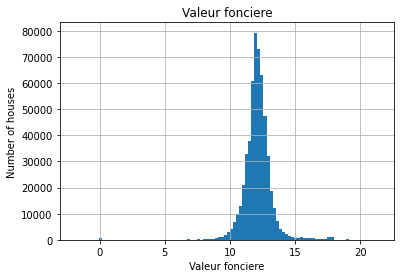

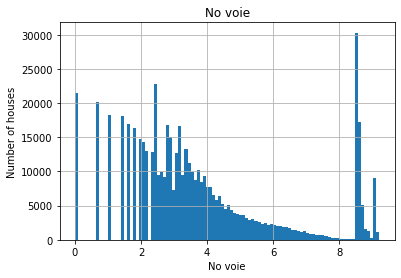

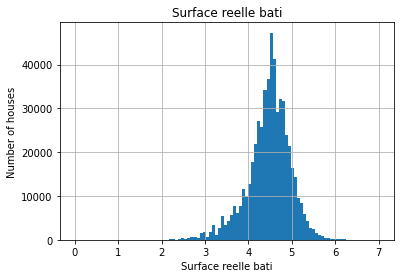

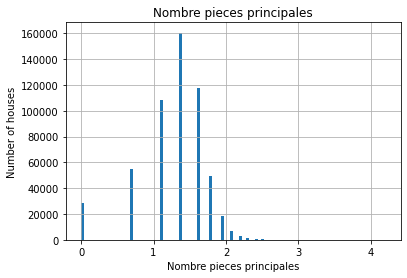

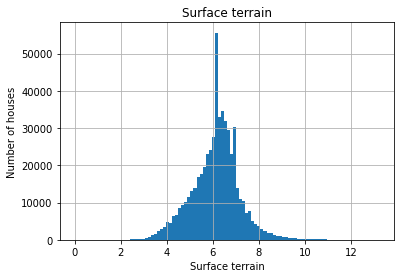

In [0]:
def analyse_transformed_continuous(df, var):
    df = df.copy()

    # log does not take 0 or negative values, so let's be
    # careful and skip those variables
    # log transform the variable
    df[var] = np.log(df[var])
    df[var].hist(bins=100)
    plt.ylabel('Number of houses')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in numerical:
    analyse_transformed_continuous(data, var)

In [0]:
for var in continuous:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [0]:
# check that test set does not contain null values in the engineered variables
[var for var in continuous if X_test[var].isnull().sum() > 0]

[]

In [0]:
# same for train set
[var for var in continuous if X_train[var].isnull().sum() > 0]

[]

## Outliers

In [0]:
# function to create histogram, Q-Q plot and
# boxplot. 
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=120)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

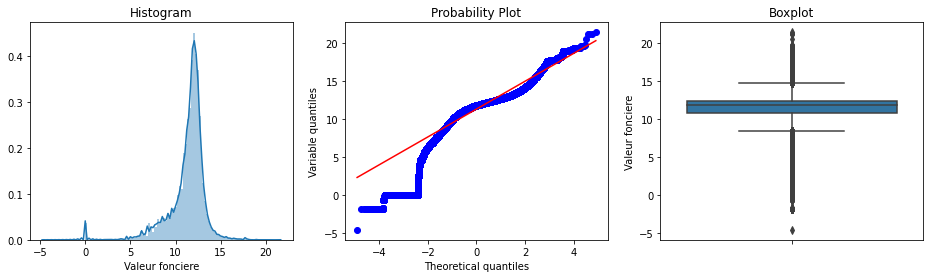

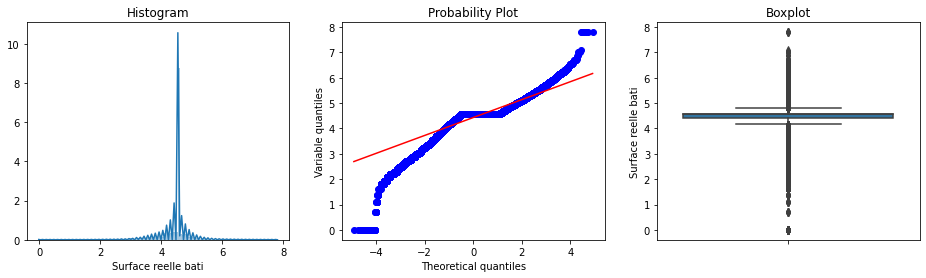

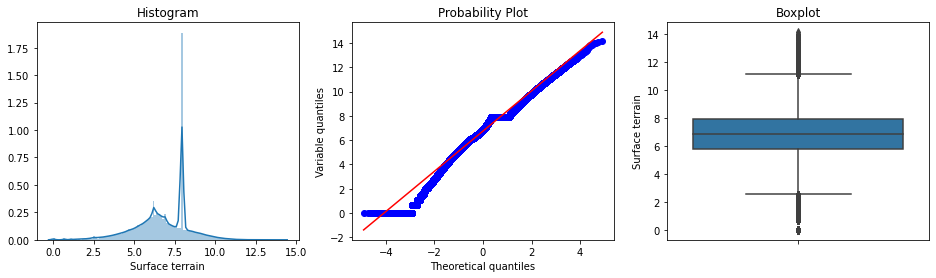

In [0]:
# let's find outliers
# for Q-Q plots
import scipy.stats as stats
for var in continuous:
    diagnostic_plots(X_train, var)


In [0]:
def find_normal_boundaries(df, variable, distance):

    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return upper_boundary, lower_boundary

In [0]:
# find limits

fonciere_upper_limit, fonciere_lower_limit = find_normal_boundaries(X_train, 'Valeur fonciere', 3)
terrain_upper_limit, terrain_lower_limit = find_normal_boundaries(X_train, 'Surface terrain', 3)
bati_upper_limit, bati_lower_limit = find_normal_boundaries(X_train, 'Surface reelle bati', 3)

In [0]:
X_train['Valeur fonciere']= np.where(X_train['Valeur fonciere'] > fonciere_upper_limit, fonciere_upper_limit,
                       np.where(X_train['Valeur fonciere'] < fonciere_lower_limit, fonciere_lower_limit, X_train['Valeur fonciere']))

In [0]:
X_train['Surface terrain']= np.where(X_train['Surface terrain'] > terrain_upper_limit, terrain_upper_limit,
                       np.where(X_train['Surface terrain'] < terrain_lower_limit, terrain_lower_limit, X_train['Surface terrain']))

In [0]:
X_train['Surface reelle bati']= np.where(X_train['Surface reelle bati'] > bati_upper_limit, bati_upper_limit,
                       np.where(X_train['Surface reelle bati'] < bati_lower_limit, bati_lower_limit, X_train['Surface reelle bati']))

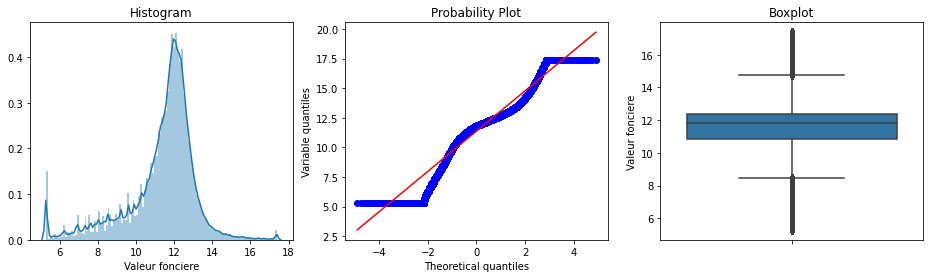

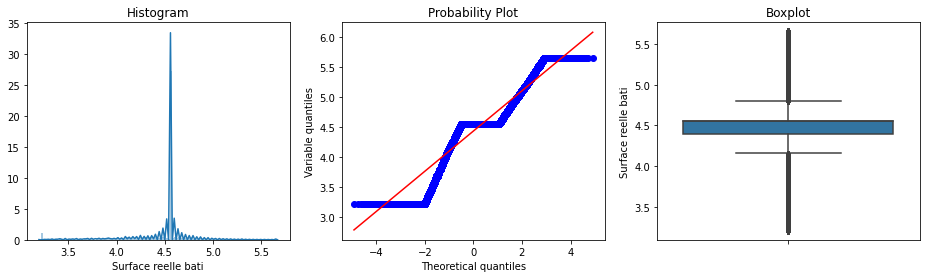

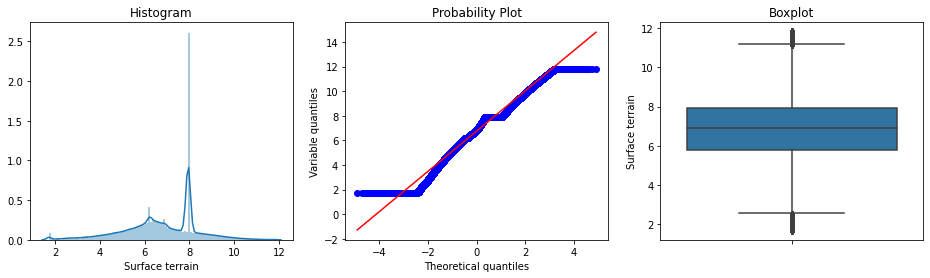

In [0]:
# let's find outliers
# for Q-Q plots
import scipy.stats as stats
for var in continuous:
    diagnostic_plots(X_train, var)


## Categorical variables



### Removing rare labels

First, we will group those categories within variables that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

In [0]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)['Valeur fonciere'].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in categorical:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')
   

### Encoding of categorical variables



In [0]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price


def replace_categories(train, test, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [0]:
for var in categorical:
    replace_categories(X_train, X_test, var, 'Valeur fonciere')

In [0]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [0]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

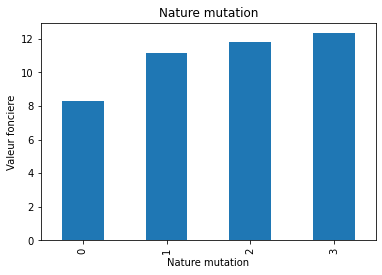

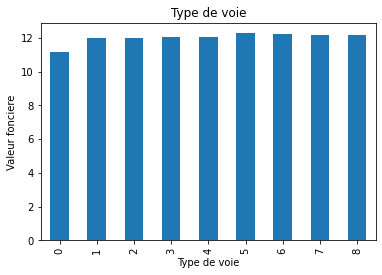

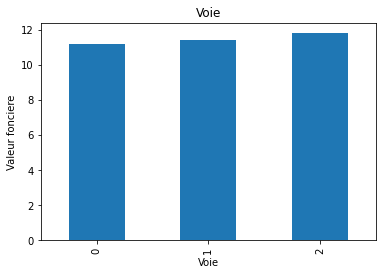

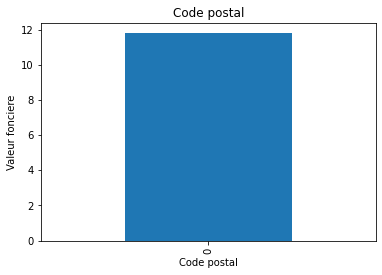

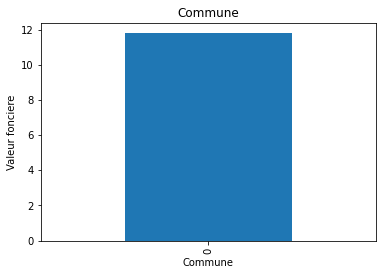

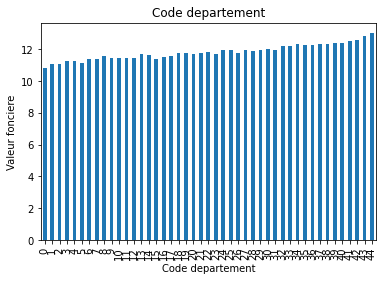

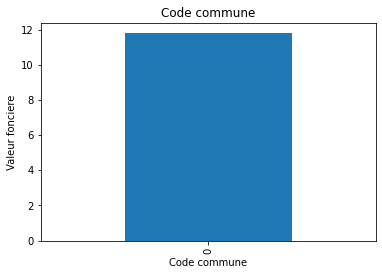

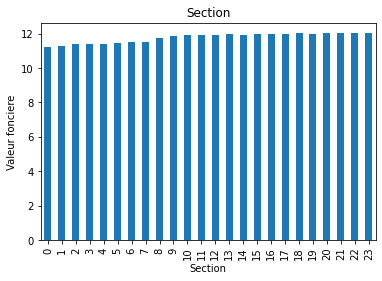

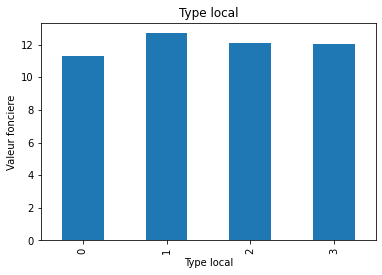

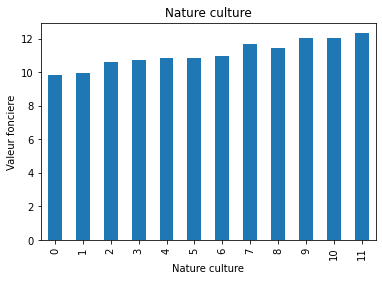

In [0]:
# let me show you what I mean by monotonic relationship
# between labels and target

def analyse_vars(df, var):
    
    # function plots median house sale price per encoded
    # category
    
    df = df.copy()
    df.groupby(var)['Valeur fonciere'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Valeur fonciere')
    plt.show()
    
for var in categorical:
    analyse_vars(X_train, var)



(the target is log-transformed, that is why the differences seem so small).

In [0]:
#sns.set(style='dark')
#sns.countplot(x='Mois mutation',data=X_train)

In [0]:
#sns.pairplot(data[['Valeur fonciere','Surface reelle bati','Nombre pieces principales']],hue='Mois mutation')

## Feature Scaling

For use in linear models, features need to be either scaled or normalised. In the next section, I will scale features to the minimum and maximum values:

In [0]:
# capture all variables in a list
# except the target and the ID

train_vars = [var for var in X_train.columns if var not in ['Valeur fonciere']]

# count number of variables
len(train_vars)

19

In [0]:
X_train.describe()

,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Code commune,Section,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain,No voie_na,Surface reelle bati_na,Nombre pieces principales_na,Surface terrain_na
count,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1556610.0,1556610.0,1.556610e+06,1556610.0,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06,1.556610e+06
mean,1.673401e+02,2.011558e+00,1.137688e+01,6.627824e+02,2.142526e+00,1.967629e+00,0.0,0.0,1.909443e+01,0.0,9.266146e+00,1.106641e+00,4.437009e+00,3.036595e+00,7.382045e+00,6.752989e+00,4.847630e-01,5.442063e-01,5.442063e-01,2.109424e-01
std,1.008999e+02,3.161964e-01,1.794263e+00,1.308448e+03,2.416209e+00,2.281086e-01,0.0,0.0,1.275934e+01,0.0,4.832307e+00,1.253297e+00,3.806655e-01,1.179663e+00,2.900938e+00,1.661195e+00,4.997679e-01,4.980421e-01,4.980421e-01,4.079777e-01
min,0.000000e+00,0.000000e+00,5.284665e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,3.215364e+00,1.000000e+00,0.000000e+00,1.701377e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+01,2.000000e+00,1.081978e+01,2.200000e+01,0.000000e+00,2.000000e+00,0.0,0.0,7.000000e+00,0.0,5.000000e+00,0.000000e+00,4.394449e+00,2.613547e+00,5.000000e+00,5.783825e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.630000e+02,2.000000e+00,1.180560e+01,7.160037e+02,1.000000e+00,2.000000e+00,0.0,0.0,1.600000e+01,0.0,1.000000e+01,0.000000e+00,4.558319e+00,2.613547e+00,9.000000e+00,6.881411e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,2.520000e+02,2.000000e+00,1.239669e+01,7.160037e+02,4.000000e+00,2.000000e+00,0.0,0.0,3.000000e+01,0.0,1.000000e+01,2.000000e+00,4.558319e+00,3.000000e+00,9.000000e+00,7.938127e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,3.640000e+02,3.000000e+00,1.737407e+01,9.999000e+03,8.000000e+00,2.000000e+00,0.0,0.0,4.400000e+01,0.0,2.300000e+01,3.000000e+00,5.647244e+00,6.700000e+01,1.100000e+01,1.179344e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [0]:
X_train.head()

,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Code commune,Section,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain,No voie_na,Surface reelle bati_na,Nombre pieces principales_na,Surface terrain_na
1437941,311,2,8.987197,26.0,4,2,0,0,7,0,8,2,4.174387,4.000000,9,5.153292,0,0,0,0
273038,209,2,11.652687,10.0,4,2,0,0,3,0,10,3,4.691348,3.000000,10,7.938127,0,0,0,1
1975083,183,2,10.404263,89.0,7,2,0,0,5,0,10,3,3.688879,1.000000,10,7.938127,0,0,0,1
1783814,156,2,12.409013,31.0,7,2,0,0,42,0,18,2,4.442651,4.000000,9,4.682131,0,0,0,0
959552,153,2,12.386309,42.0,7,2,0,0,25,0,10,0,4.558319,2.613547,9,5.700444,0,1,1,0


In [0]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 

# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])

X_test[train_vars] = scaler.transform(X_test[train_vars])

In [0]:
X_train.head()

,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Code commune,Section,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain,No voie_na,Surface reelle bati_na,Nombre pieces principales_na,Surface terrain_na
1437941,0.854396,0.666667,8.987197,0.002501,0.500,1.0,0.0,0.0,0.159091,0.0,0.347826,0.666667,0.394355,0.045455,0.818182,0.342042,0.0,0.0,0.0,0.0
273038,0.574176,0.666667,11.652687,0.000900,0.500,1.0,0.0,0.0,0.068182,0.0,0.434783,1.000000,0.606931,0.030303,0.909091,0.617986,0.0,0.0,0.0,1.0
1975083,0.502747,0.666667,10.404263,0.008802,0.875,1.0,0.0,0.0,0.113636,0.0,0.434783,1.000000,0.194712,0.000000,0.909091,0.617986,0.0,0.0,0.0,1.0
1783814,0.428571,0.666667,12.409013,0.003001,0.875,1.0,0.0,0.0,0.954545,0.0,0.782609,0.666667,0.504666,0.045455,0.818182,0.295356,0.0,0.0,0.0,0.0
959552,0.420330,0.666667,12.386309,0.004101,0.875,1.0,0.0,0.0,0.568182,0.0,0.434783,0.000000,0.552229,0.024448,0.818182,0.396259,0.0,1.0,1.0,0.0


## Closer look to target


 mu = 11.38 and sigma = 1.79



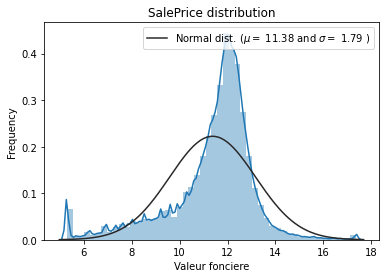

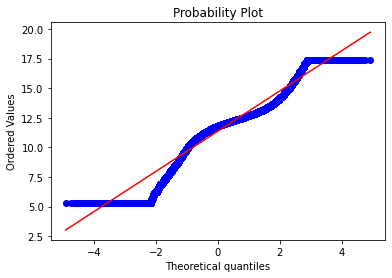

Skewness: -1.113823
Kurtosis: 2.218864


In [0]:
# Plot Histogram
sns.distplot(X_train['Valeur fonciere'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X_train['Valeur fonciere'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(X_train['Valeur fonciere'], plot=plt)
plt.show()

print("Skewness: %f" % X_train['Valeur fonciere'].skew())
print("Kurtosis: %f" % X_train['Valeur fonciere'].kurt())

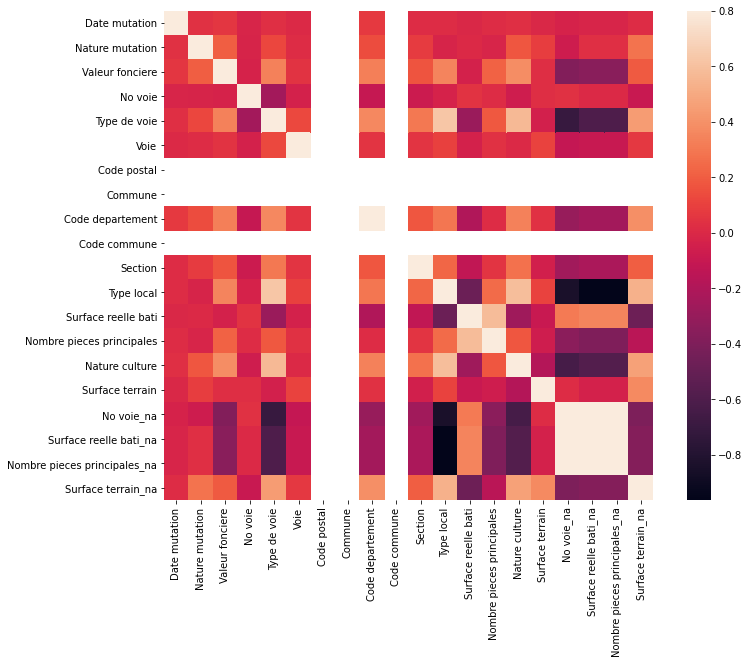

In [0]:
# Correlation Matrix Heatmap
corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## Save engineered data

In [0]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv('/content/drive/My Drive/Colab Notebooks/DVF/data/xtrain.csv', index=False)
X_test.to_csv('/content/drive/My Drive/Colab Notebooks/DVF/data/xtest.csv', index=False)

In [0]:
#fig=px.box(data,x="Mois mutation",y="Valeur fonciere", hover_data=['Voie','Code postal'])

In [0]:
#fig.show()